In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# %matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal,norm
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
def sampleGauss2D(mu,cov,xmin=-10,xmax=10,ymin=-10,ymax=10):
    """
    Given x,y mean and covariance,
    Sample 2D Gaussian Distribution Datapoints 
    within x[-10,10], y[-10,10].
    mu = [1,2] w
 x   cov = [2,2]
    """
    x = np.linspace(xmin,xmax,100)
    y = np.linspace(ymin,ymax,100)
    x,y = np.meshgrid(x,y)
    pos = np.empty(x.shape+(2,))
    pos[:,:,0]=x
    pos[:,:,1]=y
    rv = multivariate_normal(mu,cov)
    z = rv.pdf(pos)
    return x,y,z
def plot3DSurface2DContour(xs,ys,zs,xmin=-10,xmax=10,ymin=-10,ymax=10):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(121, projection='3d')
    xs=np.array(xs)
    xs=np.sum(xs,axis=0)
    ys=np.array(ys)
    ys=np.sum(ys,axis=0)
    zs=np.array(zs)
    zs=np.sum(zs,axis=0)
    zmax = np.max(zs)
    ax.set_xlim3d([xmin,xmax])
    ax.set_ylim3d([ymin,ymax])
    ax.set_zlim3d([0,zmax])
    ax.view_init(75, 100)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.plot_surface(xs,ys,zs,cmap="plasma")

    ax = fig.add_subplot(122)
    ax.contour(xs,ys,zs)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
def sampleGauss1D(mu,var):
    """
    Given x mean and variance,
    sample 1D Gaussian Distribution Datapoints
    with x[-10,10].
    mu = [1]
    cov = [1]
    """
    x = np.linspace(-10,20,10000)
    rv = norm(mu,var)
    y = rv.pdf(x)
    return x,y
def plot2D(xs,ys):
#     fig = plt.figure()
    xs = np.array(xs).sum(axis=0)
    ys = np.array(ys).sum(axis=0)
    plt.plot(xs,ys)
    plt.xlabel('x')
    plt.ylabel('y')

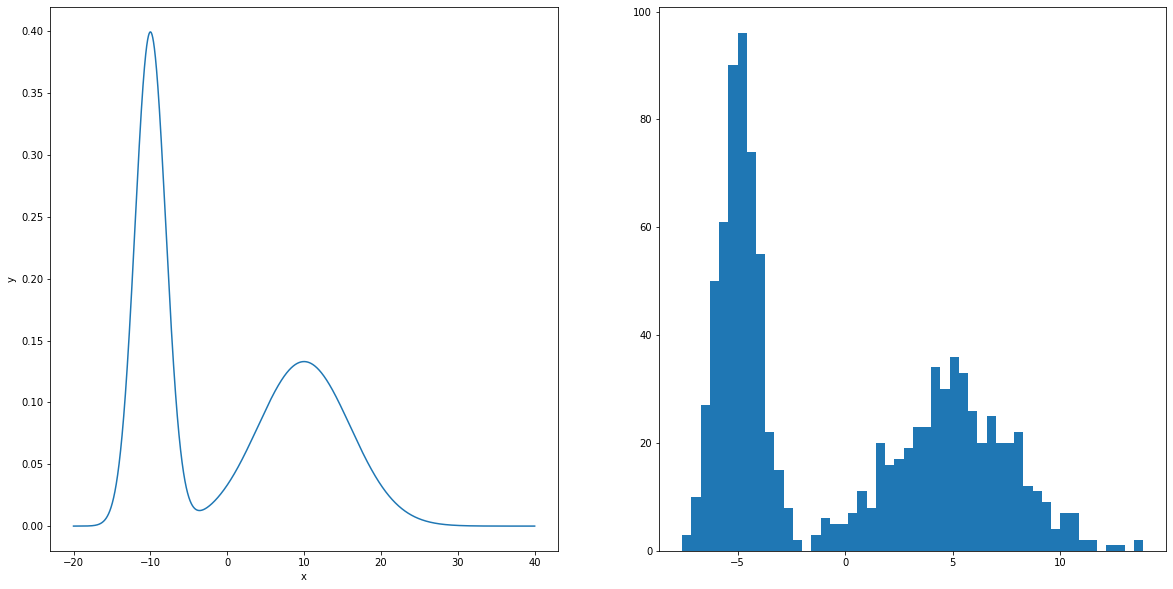

In [3]:
x0,y0 = sampleGauss1D(5,3)
x1,y1 = sampleGauss1D(-5,1)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot2D([x0,x1],[y0,y1])
N = 10000
x = np.hstack((np.random.normal(5,3,N),np.random.normal(-5,1,N)))
samples = x[np.random.randint(0,N*2,1000)]
plt.subplot(1,2,2)
_ = plt.hist(samples,bins=50)

In [29]:
class experiment:
    def __init__(self,samples):
        self.samples = samples
        self._logL = lambda m0,v0,m1,v1,m00,v00:(np.log(\
                norm.pdf(samples,m0,v0))+np.log(\
                norm.pdf(samples,m1,v1))).sum()
    def explore(self,m0,v0,m1,v1,szM,szV,T=300000):
        self.ms,self.vs = np.zeros(T),np.zeros(T)
        self.its,self.rs = np.zeros(T),np.zeros(T)
        mt0,vt0 = m0,v0
        mt1,vt1 = m1,v1
        for it in tqdm(range(T)):
            mp0 = szM*np.random.randn(1)+mt0
            vp0 = np.random.gamma(vt0,szV,1)
            mp1 = szM*np.random.randn(1)+mt1
            vp1 = np.random.gamma(vt1,szV,1)
            logR = self._logL(mp0[0],vp0[0],mp1[0],vp1[0],mt0,vt0)-\
                    self._logL(mt0,vt0,mt1,vt1,mt0,vt0)
            u = np.random.rand(1)[0]
            if self._logL(mp0[0],vp0[0],mp1[0],vp1[0],mt0,vt0)>self._logL(mt0,vt0,mt1,vt1,mt0,vt0):
                mt0,vt0 = mp0[0],vp0[0]
                mt1,vt1 = mp1[0],vp1[0]
            elif np.exp(logR)>u:
                mt0,vt0 = mp0[0],vp0[0]
                mt1,vt1 = mp1[0],vp1[0]
            self.ms[it]=mt0
            self.vs[it]=vt0
#             self.rs[it]=np.exp(logR)
            self.its[it]=it
    def mu_var_evolution(self):
        plt.figure(figsize=(20,10))
        ax1 = plt.subplot(1,2,1)
        ax1.plot(self.its,self.ms)
        ax1.set_xlabel('iterations')
        ax1.set_ylabel('mean1')

        ax2 = plt.subplot(1,2,2)
        ax2.plot(self.its,self.vs)
        ax2.set_xlabel('iterations')
        ax2.set_ylabel('mean2')
    def histPath(self,x0,y0,z0,xmin=-10,xmax=10,
                 ymin=0,ymax=15,bins=50):
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(121, projection='3d')
        x, y = np.array(self.ms),np.array(self.vs)
        hist,xedges,yedges = np.histogram2d(x,y,
                bins=bins, range=[[xmin,xmax],[ymin,ymax]])

        # Construct arrays for the anchor positions of the 16 bars.
        xpos, ypos = np.meshgrid(xedges[:-1]+0.25,
                yedges[:-1]+0.25,indexing="ij")
        xpos = xpos.ravel()
        ypos = ypos.ravel()
        zpos = 0

        # Construct arrays with the dimensions for the 16 bars.
        dx = dy = 0.5 * np.ones_like(zpos)
        dz = hist.ravel()
        offset = dz + np.abs(dz.min())
        fracs = offset.astype(float)/offset.max()
        norm = colors.Normalize(fracs.min(), fracs.max())
        cs = cm.jet(norm(fracs))

        ax1.bar3d(xpos,ypos,zpos,dx,dy,dz,zsort='average',
                  color=cs)
        ax1.view_init(75, 100)

        ax = fig.add_subplot(122)
        ax.contour(x0,y0,z0)
        ax.plot(self.ms,self.vs)
        ax.set_xlim([xmin,xmax])
        ax.set_ylim([ymin,ymax])
        ax.set_xlabel('mean1')
        ax.set_ylabel('mean2')
        ax.set_aspect('equal')

100%|██████████| 1000000/1000000 [10:06<00:00, 1649.57it/s]


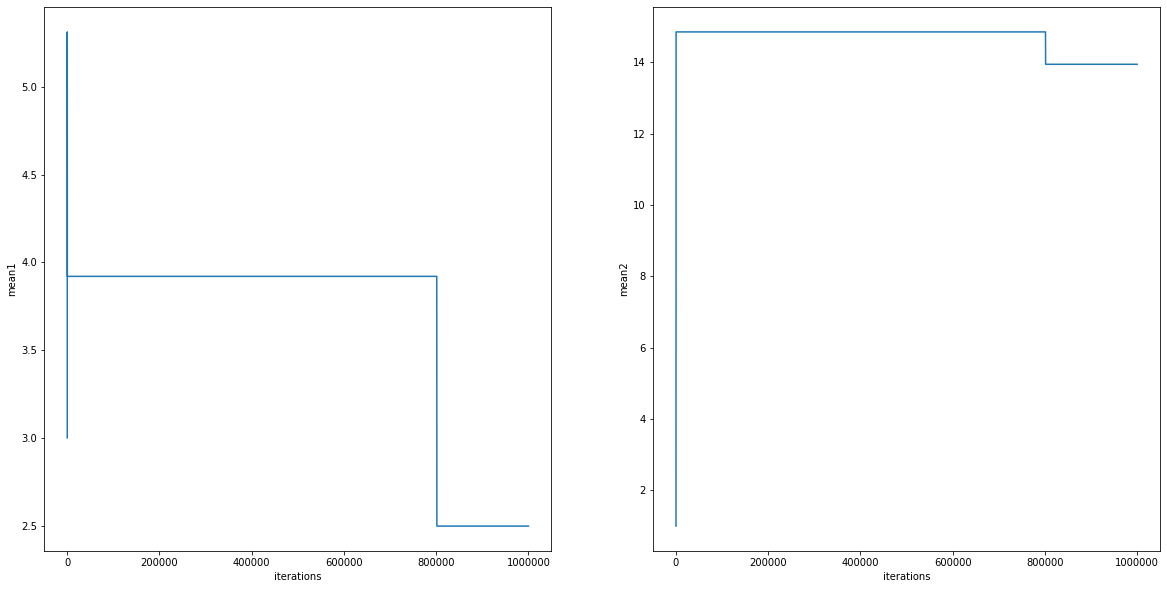

In [34]:
e = experiment(samples)
# m0,v0 = np.random.multivariate_normal([0,-1],[[1,0],[0,1]])
e.explore(3,1,-5,2,3,3,T=1000000)
e.mu_var_evolution()

In [35]:
print(e.ms[-1],e.vs[-1])

2.497378713468626 13.941053070562162


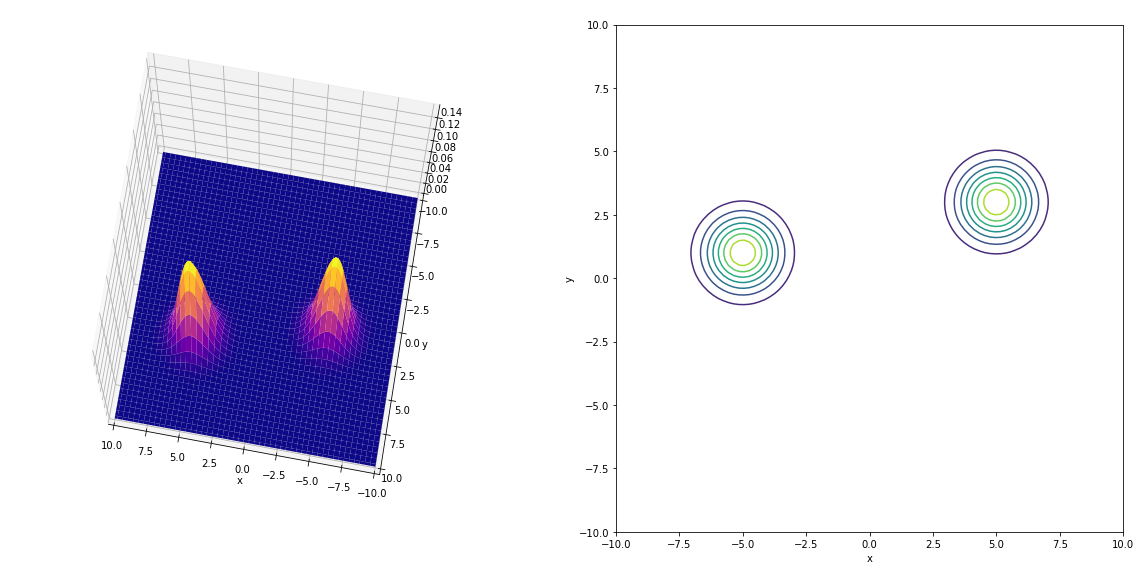

In [36]:
x0,y0,z0 = sampleGauss2D([5,3],[[1,0],[0,1]])
x1,y1,z1 = sampleGauss2D([-5,1],[[1,0],[0,1]])
plot3DSurface2DContour([x0],[y0],[z0,z1])

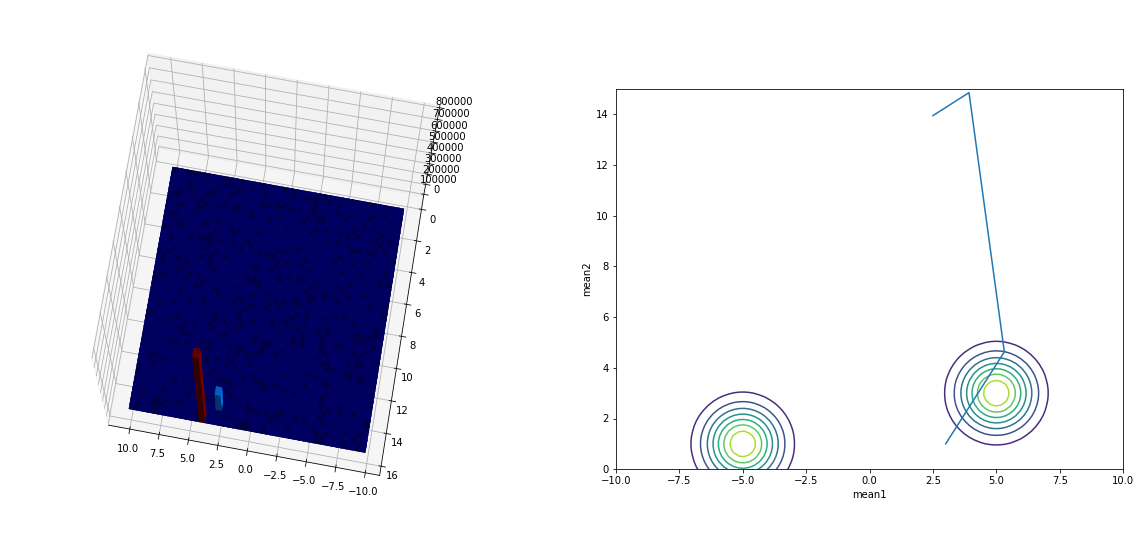

In [37]:
cz = np.array([z0,z1]).sum(axis=0)
e.histPath(x0,y0,cz)